## Imports

In [30]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

In [2]:
import torch
print(torch.cuda.is_available())  # True if GPU is accessible
print(torch.cuda.get_device_name(0))  # Name of GPU 0


True
NVIDIA RTX 2000 Ada Generation Laptop GPU


## Preprocesamiento de dataset

El dataset se ha generado de forma sintética utilizando una combinación de LLM y recopilación manual de páginas médicas como MayoClinic (poner otros). Se ha realizado una técnica de augmentación que ha sido parafrasear las frases de ejemplo para añadir complejidad, diferentes situaciones y contexto para el posterior finetuning del modelo NLP

Primero importamos un dataset con la siguiente estructura:
Síntomas de estado físco -> Ejemplos de oraciones posibles que pueden entrar como input de usuario -> deficiencia nutricional asociada -> en qué alimentos se puede encontrar los nutrientes necesarios

In [3]:
sintomas_df = pd.read_csv('..\dataset\Input - sintoma, deficiencia nutricional e ingrediente\dataset - sintomas_deficiencias_nutricionales_ingredientes.csv')

In [4]:
sintomas_df.head()

,sintoma,texto,deficiencia de nutrientes,disponible en ingredientes,source
0,fatiga,estoy constantemente cansado y sin energia,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne pavo, huevos, salmon, lech...",original
1,fatiga,estoy constantemente fatigado y muy bajo de en...,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne pavo, huevos, salmon, lech...",parafraseado
2,fatiga,por las mananas estoy constantemente cansado y...,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne pavo, huevos, salmon, lech...",parafraseado
3,fatiga,de vez en cuando estoy constantemente sin ener...,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne pavo, huevos, salmon, lech...",parafraseado
4,fatiga,me siento agotado todo el dia,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne pavo, huevos, salmon, lech...",original


In [5]:
def refinar_deficiencias(nutrientes):
    # Extraigo cada item que está delimitado por ";"
    items = [item.strip() for item in nutrientes.split(';') if item.strip()]
    # Añado la frase "deficiencia de" antes de cada nutriente para dar más contexto y mejor el entendimiento posterior del modelo NLP.
    return [f'deficiencia de {item}' for item in items]

In [6]:
sintomas_df['deficiencia de nutrientes refinado'] = sintomas_df['deficiencia de nutrientes'].apply(refinar_deficiencias)
sintomas_df.drop(columns='deficiencia de nutrientes', inplace=True)
sintomas_df.head()

,sintoma,texto,disponible en ingredientes,source,deficiencia de nutrientes refinado
0,fatiga,estoy constantemente cansado y sin energia,"carne vacuno, carne pavo, huevos, salmon, lech...",original,"[deficiencia de hierro, deficiencia de vitamin..."
1,fatiga,estoy constantemente fatigado y muy bajo de en...,"carne vacuno, carne pavo, huevos, salmon, lech...",parafraseado,"[deficiencia de hierro, deficiencia de vitamin..."
2,fatiga,por las mananas estoy constantemente cansado y...,"carne vacuno, carne pavo, huevos, salmon, lech...",parafraseado,"[deficiencia de hierro, deficiencia de vitamin..."
3,fatiga,de vez en cuando estoy constantemente sin ener...,"carne vacuno, carne pavo, huevos, salmon, lech...",parafraseado,"[deficiencia de hierro, deficiencia de vitamin..."
4,fatiga,me siento agotado todo el dia,"carne vacuno, carne pavo, huevos, salmon, lech...",original,"[deficiencia de hierro, deficiencia de vitamin..."


In [32]:
# ========== 1) SPLIT TRAIN/VAL/TEST ==========
# Stratified para que cada simtoma por lo menos esté en train, val, test una vez
seed = 1234

# 1) Train/test split (15% test)
train_df, test_df = train_test_split(
    sintomas_df,
    test_size=0.15,
    stratify=sintomas_df["sintoma"],
    random_state=seed
)

# 2) Train/val split from the training portion (15% val of remaining 85%)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df["sintoma"],
    random_state=seed
)

# -------------------------------------------------------------------------
df = sintomas_df.copy()

# Ensure the columns are correct
assert {"texto", "sintoma"}.issubset(df.columns)

# =========================================================
# 1) CLOSED-WORLD: Stratified random split
# =========================================================
train_strat, test_strat = train_test_split(
    df,
    test_size=0.15,
    stratify=df["sintoma"],
    random_state=seed
)
train_strat, val_strat = train_test_split(
    train_strat,
    test_size=0.15,
    stratify=train_strat["sintoma"],
    random_state=seed
)

# =========================================================
# 2) OPEN-WORLD: Group-by-symptom split
# =========================================================
gss = GroupShuffleSplit(test_size=0.15, n_splits=1, random_state=seed)
groups = df["sintoma"]

train_idx, test_idx = next(gss.split(df, groups=groups))
train_group_df = df.iloc[train_idx]
test_group_df = df.iloc[test_idx]

# Split train_group_df into train/val (still grouping)
gss_val = GroupShuffleSplit(test_size=0.15, n_splits=1, random_state=seed)
groups_train = train_group_df["sintoma"]
train_idx2, val_idx = next(gss_val.split(train_group_df, groups=groups_train))
train_group = train_group_df.iloc[train_idx2]
val_group = train_group_df.iloc[val_idx]
test_group = test_group_df

# =========================================================
# 3) FULLY RANDOM: No stratify, no grouping
# =========================================================
train_rand, test_rand = train_test_split(
    df,
    test_size=0.15,
    random_state=seed
)
train_rand, val_rand = train_test_split(
    train_rand,
    test_size=0.15,
    random_state=seed
)

# =========================================================
# Reset indices
# =========================================================
def reset_all(*dfs):
    return [d.reset_index(drop=True) for d in dfs]

(train_strat, val_strat, test_strat,
 train_group, val_group, test_group,
 train_rand, val_rand, test_rand) = reset_all(
    train_strat, val_strat, test_strat,
    train_group, val_group, test_group,
    train_rand, val_rand, test_rand
)

# =========================================================
# Quick sanity checks
# =========================================================
print("\n=== Stratified split ===")
print(f"Train: {len(train_strat)}, Val: {len(val_strat)}, Test: {len(test_strat)}")
print("Symptoms in train:", train_strat["sintoma"].nunique(),
      "| val:", val_strat["sintoma"].nunique(),
      "| test:", test_strat["sintoma"].nunique())

print("\n=== Group-by-symptom split ===")
print(f"Train: {len(train_group)}, Val: {len(val_group)}, Test: {len(test_group)}")
print("Symptoms in train:", train_group["sintoma"].nunique(),
      "| val:", val_group["sintoma"].nunique(),
      "| test:", test_group["sintoma"].nunique())

print("\n=== Fully random split ===")
print(f"Train: {len(train_rand)}, Val: {len(val_rand)}, Test: {len(test_rand)}")
print("Symptoms in train:", train_rand["sintoma"].nunique(),
      "| val:", val_rand["sintoma"].nunique(),
      "| test:", test_rand["sintoma"].nunique())



# Reset indices
df_train = train_df.reset_index(drop=True)
df_val = val_df.reset_index(drop=True)
df_test = test_df.reset_index(drop=True)

# Conservando stratified y proporciones
print(f"Numero de filas en train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")
print("Simptomas unicas en train:", df_train["sintoma"].nunique())
print("Simptomas unicas en val:", df_val["sintoma"].nunique())
print("Simptomas unicas en test:", df_test["sintoma"].nunique())



=== Stratified split ===
Train: 549, Val: 97, Test: 114
Symptoms in train: 38 | val: 38 | test: 38

=== Group-by-symptom split ===
Train: 540, Val: 100, Test: 120
Symptoms in train: 27 | val: 5 | test: 6

=== Fully random split ===
Train: 549, Val: 97, Test: 114
Symptoms in train: 38 | val: 35 | test: 38
Numero de filas en train: 549, val: 97, test: 114
Simptomas unicas en train: 38
Simptomas unicas en val: 38
Simptomas unicas en test: 38


In [33]:
def reset_all(*dfs):
    return [d.reset_index(drop=True) for d in dfs]

(train_strat, val_strat, test_strat,
 train_group, val_group, test_group,
 train_rand, val_rand, test_rand) = reset_all(
    train_strat, val_strat, test_strat,
    train_group, val_group, test_group,
    train_rand, val_rand, test_rand
)

# =========================================================
# Quick sanity checks
# =========================================================
print("\n=== Stratified split ===")
print(f"Train: {len(train_strat)}, Val: {len(val_strat)}, Test: {len(test_strat)}")
print("Symptoms in train:", train_strat["sintoma"].nunique(),
      "| val:", val_strat["sintoma"].nunique(),
      "| test:", test_strat["sintoma"].nunique())

print("\n=== Group-by-symptom split ===")
print(f"Train: {len(train_group)}, Val: {len(val_group)}, Test: {len(test_group)}")
print("Symptoms in train:", train_group["sintoma"].nunique(),
      "| val:", val_group["sintoma"].nunique(),
      "| test:", test_group["sintoma"].nunique())

print("\n=== Fully random split ===")
print(f"Train: {len(train_rand)}, Val: {len(val_rand)}, Test: {len(test_rand)}")
print("Symptoms in train:", train_rand["sintoma"].nunique(),
      "| val:", val_rand["sintoma"].nunique(),
      "| test:", test_rand["sintoma"].nunique())


=== Stratified split ===
Train: 549, Val: 97, Test: 114
Symptoms in train: 38 | val: 38 | test: 38

=== Group-by-symptom split ===
Train: 540, Val: 100, Test: 120
Symptoms in train: 27 | val: 5 | test: 6

=== Fully random split ===
Train: 549, Val: 97, Test: 114
Symptoms in train: 38 | val: 35 | test: 38


In [10]:
# ==============================
# 2) Label mapping (symptom <-> id)
# ==============================
all_symptoms = sorted(sintomas_df["sintoma"].unique())
sym2id = {sintoma:i for i,sintoma in enumerate(all_symptoms)}
id2sym = {i:sintoma for sintoma,i in sym2id.items()}

for df in (df_train, df_val, df_test):
    df["label"] = df["sintoma"].map(sym2id).astype(int)   # single integer label

In [12]:
# ========== 3) DATASETS HF + TOKENIZACION ==========
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train[['texto', 'label']].rename(columns={"texto":"text"})),
    "validation": Dataset.from_pandas(df_val[['texto', 'label']].rename(columns={"texto":"text"})),
    "test": Dataset.from_pandas(df_test[['texto', 'label']].rename(columns={"texto":"text"})),
})

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format(type="torch")

Map: 100%|██████████| 114/114 [00:00<00:00, 3537.30 examples/s]


## 1st run - Stratified

In [18]:
# ========== 4) MODELO + TRAINER ==========
num_labels = len(all_symptoms)
model_NLP = AutoModelForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels
)

# Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

args = TrainingArguments(
    output_dir="..\\model runs\\NLP runs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_strategy="steps",
    logging_steps=1,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",          
    save_strategy="epoch",
    load_best_model_at_end=True,      
    metric_for_best_model="eval_loss",        
    greater_is_better=False,
    fp16=True,
    seed=seed
)

trainer = Trainer(
    model=model_NLP,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

print("Entrenamiento en proceso")
trainer.train()
evaluate_results = trainer.evaluate(dataset["test"])
print("Evaluación test y métricas:", evaluate_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\oscar.xu\AppData\Local\Temp\ipykernel_14120\2678836874.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entrenamiento en proceso


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,3.554700,3.425318,0.216495,0.166731,0.195102,0.232456
2,2.965600,2.875765,0.670103,0.657690,0.746637,0.679825
3,2.449200,2.288932,0.886598,0.859837,0.868860,0.885965
4,1.919700,1.790251,0.927835,0.901754,0.890351,0.929825
5,1.326200,1.378433,0.948454,0.928947,0.929825,0.947368
6,0.932700,1.071425,0.958763,0.942105,0.938596,0.956140
7,0.801900,0.861464,0.969072,0.952632,0.947368,0.964912
8,0.861800,0.727348,0.979381,0.963158,0.956140,0.973684
9,0.602600,0.650260,0.979381,0.964662,0.958333,0.973684
10,0.847600,0.626852,0.979381,0.964662,0.958333,0.973684


Evaluación test y métricas: {'eval_loss': 0.5954076051712036, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_precision_macro': 1.0, 'eval_recall_macro': 1.0, 'eval_runtime': 0.2833, 'eval_samples_per_second': 402.464, 'eval_steps_per_second': 14.122, 'epoch': 10.0}


## 2nd run - Avoid data leakage - groupped

In [34]:
# ==============================
# 2) Label mapping (symptom <-> id)
# ==============================
all_symptoms = sorted(sintomas_df["sintoma"].unique())
sym2id = {sintoma:i for i,sintoma in enumerate(all_symptoms)}
id2sym = {i:sintoma for sintoma,i in sym2id.items()}

for df in (train_group, test_group, val_group):
    df["label"] = df["sintoma"].map(sym2id).astype(int)   # single integer label


# ========== 3) DATASETS HF + TOKENIZACION ==========
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_group[['texto', 'label']].rename(columns={"texto":"text"})),
    "validation": Dataset.from_pandas(val_group[['texto', 'label']].rename(columns={"texto":"text"})),
    "test": Dataset.from_pandas(test_group[['texto', 'label']].rename(columns={"texto":"text"})),
})

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format(type="torch")

# ========== 4) MODELO + TRAINER ==========
num_labels = len(all_symptoms)
model_NLP = AutoModelForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels
)

# Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

args = TrainingArguments(
    output_dir="..\\model runs\\NLP runs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_strategy="steps",
    logging_steps=1,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",          
    save_strategy="epoch",
    load_best_model_at_end=True,      
    metric_for_best_model="eval_loss",        
    greater_is_better=False,
    fp16=True,
    seed=seed
)

trainer = Trainer(
    model=model_NLP,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

print("Entrenamiento en proceso")
trainer.train()
evaluate_results = trainer.evaluate(dataset["test"])
print("Evaluación test y métricas:", evaluate_results)

Map: 100%|██████████| 120/120 [00:00<00:00, 8829.80 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\oscar.xu\AppData\Local\Temp\ipykernel_14120\1066963510.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entrenamiento en proceso


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,3.348100,4.500351,0.000000,0.000000,0.000000,0.000000
2,2.527300,4.402988,0.000000,0.000000,0.000000,0.000000
3,1.903200,4.439844,0.000000,0.000000,0.000000,0.000000
4,1.291700,4.412890,0.000000,0.000000,0.000000,0.000000
5,0.765000,4.479765,0.000000,0.000000,0.000000,0.000000
6,0.499000,4.530410,0.000000,0.000000,0.000000,0.000000
7,0.381000,4.579922,0.000000,0.000000,0.000000,0.000000


Evaluación test y métricas: {'eval_loss': 4.4237141609191895, 'eval_accuracy': 0.0, 'eval_f1_macro': 0.0, 'eval_precision_macro': 0.0, 'eval_recall_macro': 0.0, 'eval_runtime': 0.3332, 'eval_samples_per_second': 360.108, 'eval_steps_per_second': 12.004, 'epoch': 7.0}


## 3rd run - All random split

In [35]:
# ==============================
# 2) Label mapping (symptom <-> id)
# ==============================
all_symptoms = sorted(sintomas_df["sintoma"].unique())
sym2id = {sintoma:i for i,sintoma in enumerate(all_symptoms)}
id2sym = {i:sintoma for sintoma,i in sym2id.items()}

for df in (train_rand, test_rand, val_rand):
    df["label"] = df["sintoma"].map(sym2id).astype(int)   # single integer label


# ========== 3) DATASETS HF + TOKENIZACION ==========
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_rand[['texto', 'label']].rename(columns={"texto":"text"})),
    "validation": Dataset.from_pandas(val_rand[['texto', 'label']].rename(columns={"texto":"text"})),
    "test": Dataset.from_pandas(test_rand[['texto', 'label']].rename(columns={"texto":"text"})),
})

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format(type="torch")

# ========== 4) MODELO + TRAINER ==========
num_labels = len(all_symptoms)
model_NLP = AutoModelForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels
)

# Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

args = TrainingArguments(
    output_dir="..\\model runs\\NLP runs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_strategy="steps",
    logging_steps=1,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",          
    save_strategy="epoch",
    load_best_model_at_end=True,      
    metric_for_best_model="eval_loss",        
    greater_is_better=False,
    fp16=True,
    seed=seed
)

trainer = Trainer(
    model=model_NLP,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

print("Entrenamiento en proceso")
trainer.train()
evaluate_results = trainer.evaluate(dataset["test"])
print("Evaluación test y métricas:", evaluate_results)

Map: 100%|██████████| 114/114 [00:00<00:00, 10623.92 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\oscar.xu\AppData\Local\Temp\ipykernel_14120\1538629374.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entrenamiento en proceso


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,3.510200,3.546633,0.082474,0.066690,0.095449,0.119369
2,3.175400,3.111388,0.463918,0.426775,0.467168,0.499561
3,2.702900,2.596287,0.711340,0.678314,0.718790,0.731532
4,2.760900,2.130467,0.855670,0.798701,0.811712,0.823874
5,1.430200,1.660423,0.917526,0.883917,0.903241,0.890741
6,1.392100,1.333954,0.938144,0.909524,0.923611,0.909259
7,1.017600,1.085590,0.969072,0.947755,0.950000,0.952381
8,0.992800,0.919632,0.979381,0.980408,0.985714,0.980952
9,0.695000,0.831825,0.979381,0.980408,0.985714,0.980952
10,0.872200,0.796759,0.989691,0.990204,0.992857,0.990476


Evaluación test y métricas: {'eval_loss': 0.7602603435516357, 'eval_accuracy': 0.9824561403508771, 'eval_f1_macro': 0.982456140350877, 'eval_precision_macro': 0.9868421052631579, 'eval_recall_macro': 0.9868421052631579, 'eval_runtime': 0.2857, 'eval_samples_per_second': 398.979, 'eval_steps_per_second': 13.999, 'epoch': 10.0}


In [38]:
def predict_symptom(texts):
    if isinstance(texts, str):
        texts = [texts]
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=256)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred_ids = np.argmax(probs, axis=1)
    results = []
    for t, pid, pvec in zip(texts, pred_ids, probs):
        results.append({"text": t, "pred_symptom": id2sym[pid], "confidence": float(pvec[pid])})
    return results

# Example:
print(predict_symptom("Últimamente mi cabeza me duele muchísimo diariamente"))


[{'text': 'Últimamente mi cabeza me duele muchísimo diariamente', 'pred_symptom': 'dolor de cabeza', 'confidence': 0.3047117292881012}]


In [39]:
# Lista de frases para probar
frases_prueba = [
    "Últimamente me siento agotado todo el día aunque duerma bien.",
    "Tengo cólicos muy fuertes cada mes antes de mi periodo.",
    "Mi piel está áspera y se descama con facilidad.",
    "Se me está cayendo mucho el cabello desde hace unas semanas.",
    "Me cuesta concentrarme y me siento sin energía.",
    "El dolor menstrual me impide hacer mis actividades diarias.",
    "La piel de mis manos está seca y agrietada.",
    "Cada vez que me cepillo el pelo, se me queda un montón en el cepillo.",
    "Me siento débil y sin fuerzas incluso después de descansar.",
    "Tengo calambres abdominales intensos durante mi menstruación."
]

# Ejecutar predicciones
resultados = predict_symptom(frases_prueba)

# Mostrar resultados
for r in resultados:
    print(f"Texto: {r['text']}")
    print(f"Predicción: {r['pred_symptom']} (confianza: {r['confidence']:.2f})")
    print("-" * 50)


Texto: Últimamente me siento agotado todo el día aunque duerma bien.
Predicción: fatiga (confianza: 0.32)
--------------------------------------------------
Texto: Tengo cólicos muy fuertes cada mes antes de mi periodo.
Predicción: calambres menstruales (confianza: 0.26)
--------------------------------------------------
Texto: Mi piel está áspera y se descama con facilidad.
Predicción: piel seca (confianza: 0.60)
--------------------------------------------------
Texto: Se me está cayendo mucho el cabello desde hace unas semanas.
Predicción: caida de cabello (confianza: 0.67)
--------------------------------------------------
Texto: Me cuesta concentrarme y me siento sin energía.
Predicción: fatiga (confianza: 0.15)
--------------------------------------------------
Texto: El dolor menstrual me impide hacer mis actividades diarias.
Predicción: calambres menstruales (confianza: 0.22)
--------------------------------------------------
Texto: La piel de mis manos está seca y agrietada.
P


=== Classification Report ===
                                 precision    recall  f1-score   support

                     animo bajo       1.00      1.00      1.00         3
                       ansiedad       1.00      1.00      1.00         3
               caida de cabello       1.00      1.00      1.00         3
          calambres menstruales       1.00      1.00      1.00         3
           calambres musculares       1.00      1.00      1.00         3
            calambres nocturnos       1.00      1.00      1.00         3
           cansancio tras comer       1.00      1.00      1.00         3
              debilidad general       1.00      1.00      1.00         3
             debilidad muscular       1.00      1.00      1.00         3
 deficit de vitamina d sospecha       1.00      1.00      1.00         3
                     dermatitis       1.00      1.00      1.00         3
   dificultad para concentrarse       1.00      1.00      1.00         3
                dol

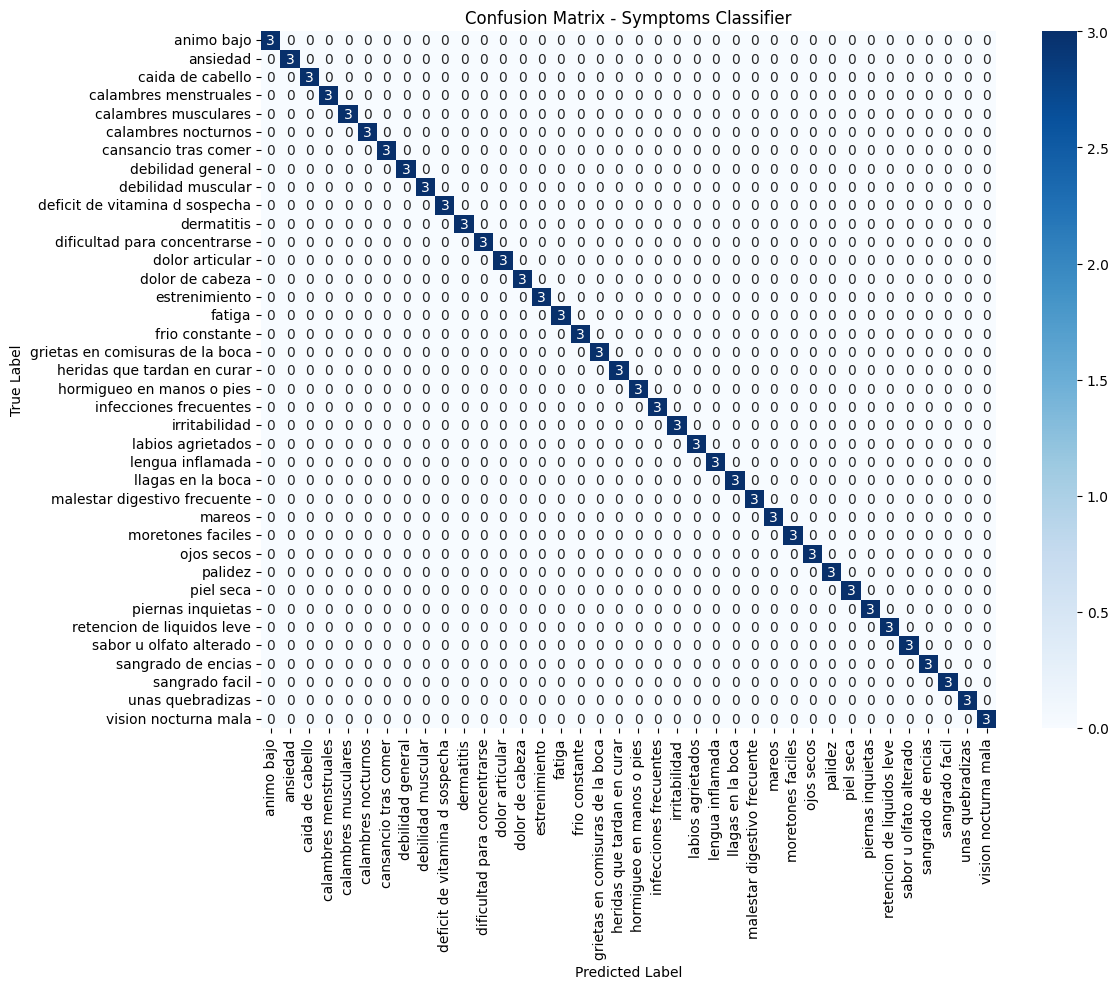

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions on the test set
pred_output = trainer.predict(dataset["test"])
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(all_symptoms)))

# Print classification report for precision/recall/F1
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=all_symptoms, zero_division=0))

# Plot with Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_symptoms,
            yticklabels=all_symptoms)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Symptoms Classifier')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Guardar el modelo

In [21]:
best_ckpt = trainer.state.best_model_checkpoint
print("Best checkpoint:", best_ckpt)

export_dir = r"../model runs\NLP final model"
os.makedirs(export_dir, exist_ok=True)
trainer.save_model(export_dir)          # saves model + config from the best weights
tokenizer.save_pretrained(export_dir)   # save tokenizer too

# If you have sym2id:
pd.Series(sym2id).to_json(
    os.path.join(export_dir, "symptom2id.json"),
    force_ascii=False
)


Best checkpoint: ..\model runs\NLP runs\checkpoint-350


## Prediction

In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

# Path where you saved it after training
model_dir = r"../model runs\NLP final model"

model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# If you saved the mapping file:
import json
with open(f"{model_dir}/symptom2id.json", "r", encoding="utf-8") as f:
    sym2id = json.load(f)
id2sym = {int(v): k for k, v in sym2id.items()}


In [24]:
def predict_symptom(texts):
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

    model.eval()
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

    results = []
    for text, pred_id, prob in zip(texts, preds, probs):
        label = id2sym[pred_id]
        confidence = prob[pred_id]
        results.append({"text": text, "predicted_symptom": label, "confidence": confidence})
    return results


In [29]:
samples = [
    "últimamente me duele la cabeza",
    "Se me cae más el pelo cuando me ducho",
    "La regla me duele mucho",

]

predictions = predict_symptom(samples)
for p in predictions:
    print(f"Texto: {p['text']}")
    print(f"Predicción: {p['predicted_symptom']} (confianza {p['confidence']:.2f})\n")


Texto: últimamente me duele la cabeza
Predicción: dolor de cabeza (confianza 0.56)

Texto: Se me cae más el pelo cuando me ducho
Predicción: caida de cabello (confianza 0.57)

Texto: La regla me duele mucho
Predicción: calambres menstruales (confianza 0.47)

